In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

/Users/carsonransford/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
tf.__version__

'2.11.0'

In [3]:
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

if os.path.exists(csv_file):
    print('Path already exists - Downloading data from local directory')
    dataframe = pd.read_csv(csv_file)
else: 
    print('File path does not exist - downloading data and creating path...')
    dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'

    tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                            extract=True, cache_dir='.')
    
    dataframe = pd.read_csv(csv_file)

Path already exists - Downloading data from local directory


In [4]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [5]:
dataframe.dtypes

Type             object
Age               int64
Breed1           object
Gender           object
Color1           object
Color2           object
MaturitySize     object
FurLength        object
Vaccinated       object
Sterilized       object
Health           object
Fee               int64
Description      object
PhotoAmt          int64
AdoptionSpeed     int64
dtype: object

In [6]:
dataframe['AdoptionSpeed'].value_counts()

2    3153
4    3080
3    2543
1    2432
0     329
Name: AdoptionSpeed, dtype: int64

In [7]:
dataframe['Age'] = dataframe['Age'].astype(float)
dataframe['Fee'] = dataframe['Fee'].astype(float)
dataframe['PhotoAmt'] = dataframe['PhotoAmt'].astype(float)

### Data Preprocessing

In [8]:
# Remove listing description for now - To be approached with NLP later
dataframe = dataframe.drop(columns=['Description'])

In [9]:
# Split data into training, validation, test
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


Create function that converts each training, validation, and test set dataframe into a tensorflow dataset, then shuffles and batches the data

In [10]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('AdoptionSpeed')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

Use our function to check the format of the data the input pipeline helper function returns by calling it on the training, validation, and test data - use a small batch size to keep the output readable

In [11]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

The function returns a dictionary of column names that map to column values from rows in the dataframe

In [13]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 3.  3. 24.  1.  2.], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([2 3 4 2 1], shape=(5,), dtype=int64)


### Demonstrate several types of feature columns
TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [14]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [16]:
# A utility method to create a feature column and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

### Numeric Columns
The output of a feature column becomes the input to the model (using the demo function defined above, we will be able to see exactly how each column from the dataframe is transformed). A numeric column is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [17]:
photo_count = feature_column.numeric_column('PhotoAmt')
demo(photo_count)

[[5.]
 [3.]
 [2.]
 [3.]
 [1.]]


### Binning Numeric Columns & Converting to Categorical
Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a bucketized column. Notice the one-hot values below describe which age range each row matches.

In [18]:
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


### Categorical Columns
In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot encoded vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using categorical_column_with_vocabulary_list, or loaded from a file using categorical_column_with_vocabulary_file.

In [19]:
animal_type = feature_column.categorical_column_with_vocabulary_list(
      'Type', ['Cat', 'Dog'])

animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### Embedding Columns
Suppose instead of having just a few possible strings, we have thousands (or more) values per category. For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an embedding column represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.

Using an embedding column is best when a categorical column has many possible values. We are using one here for demonstration purposes, so you have a complete example you can modify for a different dataset in the future.

In [20]:
# Notice the input to the embedding column is the categorical column we previously created
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())

breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[ 0.13095444  0.3269618   0.06652604  0.33797476  0.4567519  -0.12992768
  -0.32599676  0.41565028]
 [ 0.13095444  0.3269618   0.06652604  0.33797476  0.4567519  -0.12992768
  -0.32599676  0.41565028]
 [-0.43639672 -0.68780476 -0.3431891  -0.44240505 -0.43225065  0.5802698
   0.3156668  -0.02734345]
 [-0.15524973  0.2837961  -0.32624674 -0.00208446 -0.12058996  0.1886612
  -0.6025837  -0.3836936 ]
 [-0.43639672 -0.68780476 -0.3431891  -0.44240505 -0.43225065  0.5802698
   0.3156668  -0.02734345]]


### Hashed Feature Columns
Another way to represent a categorical column with a large number of values is to use a ```categorical_column_with_hash_bucket```. This feature column calculates a hash value of the input, then selects one of the ```hash_bucket_size``` buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some datasets regardless.

In [21]:
breed1_hashed = feature_column.categorical_column_with_hash_bucket(
      'Breed1', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


### Crossed Feature Columns
Combining features into a single feature, better known as feature crosses, enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of Age and Type. Note that crossed_column does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a hashed_column, so you can choose how large the table is.

In [22]:
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### Feature Selection

In [26]:
def get_normalization_parameters(traindf, features):
  def _z_score_params(column):
    mean = traindf[column].mean()
    std = traindf[column].std()
    return {'mean': mean, 'std': std}
  
  normalization_parameters = {}
  for column in features:
    normalization_parameters[column] = _z_score_params(column)
  return normalization_parameters

num_cols = ['PhotoAmt', 'Fee', 'Age']

normalization_parameters = get_normalization_parameters(train,
                                                        num_cols)
normalization_parameters

{'PhotoAmt': {'mean': 3.634159555736151, 'std': 3.1428740244518476},
 'Fee': {'mean': 24.29527292428552, 'std': 80.78659142942719},
 'Age': {'mean': 11.81511580658269, 'std': 19.620072745746032}}

In [27]:
def _numeric_column_normalized(column_name, normalizer_fn):
  return tf.feature_column.numeric_column(column_name,
                                          normalizer_fn=normalizer_fn)


def create_feature_cols(features, use_normalization):
    normalized_feature_columns = []
    for column_name in features:
        if use_normalization:
            column_params = normalization_parameters[column_name]
            mean = column_params['mean']
            std = column_params['std']
            def normalize_column(col):
                return (col - mean)/std
            normalizer_fn = normalize_column
        else:
            normalizer_fn = None
            
        normalized_feature_columns.append(_numeric_column_normalized(column_name,
                                                              normalizer_fn))
        print(normalized_feature_columns)
    return normalized_feature_columns

feature_columns = create_feature_cols(num_cols, True)

[NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a138c8>)]
[NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a138c8>), NumericColumn(key='Fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a9d1e0>)]
[NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a138c8>), NumericColumn(key='Fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a9d1e0>), NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7f

In [28]:
# bucketized cols
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

In [29]:
# indicator_columns
indicator_column_names = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, dataframe[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

In [31]:
# embedding columns
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [32]:
breed1_embedding

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Breed1', vocabulary_list=('Tabby', 'Domestic Medium Hair', 'Mixed Breed', 'Domestic Short Hair', 'Domestic Long Hair', 'Terrier', 'Persian', 'Rottweiler', 'Jack Russell Terrier', 'Shih Tzu', 'Labrador Retriever', 'Silky Terrier', 'Bombay', 'Husky', 'Schnauzer', 'Golden Retriever', 'Siberian Husky', 'Collie', 'German Shepherd Dog', 'Siamese', 'Calico', 'American Staffordshire Terrier', 'Turkish Van', 'Doberman Pinscher', 'Oriental Short Hair', 'Beagle', 'Ragdoll', 'Cocker Spaniel', 'Poodle', 'Black Labrador Retriever', 'Bengal', 'Shar Pei', 'Spitz', 'Birman', 'Belgian Shepherd Malinois', 'American Shorthair', 'Belgian Shepherd Laekenois', '0', 'Jack Russell Terrier (Parson Russell Terrier)', 'Shepherd', 'Corgi', 'Pit Bull Terrier', 'Oriental Tabby', 'Miniature Pinscher', 'Manx', 'Boxer', 'Dachshund', 'Chihuahua', 'Snowshoe', 'Rat Terrier', 'Tiger', 'Silver', 'Maine Coon', 'German Pinscher', 'Russian Blue', 'Tuxedo',

In [33]:
# crossed columns
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

In [34]:
feature_columns

[NumericColumn(key='PhotoAmt', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a138c8>),
 NumericColumn(key='Fee', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a9d1e0>),
 NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function create_feature_cols.<locals>.normalize_column at 0x7fc0f9a9d378>),
 BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1, 2, 3, 4, 5)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Type', vocabulary_list=('Cat', 'Dog'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Color1', vocabulary_list=('Black', 'Brown', 'Cream', 'Gray', 'Golden', 'White', 'Yellow'), dtype

### Create A Feature Layer
Use ```DenseFeatures``` layer to input our feature columns to our Keras model

In [35]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Previous use of smaller batch size was intended for demonstration purposes only. We are now creating a new pipeline with a larger batch size for model training purposes. 

In [36]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Create, Compile, and Train
Use a Learning Rate Scheduler to increase the learning rate by 10 to the power of 50 epochs / 20, starting at 0.001. The performance of the model will be tracked as the learning rate increases within ```find_lr_history```.

In [37]:
tf.random.set_seed(42)
epochs=50

model_1 = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax"),
])

model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"]
               )

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

find_lr_history = model_1.fit(train_ds,
                             validation_data = val_ds,
                             epochs=epochs,
                             callbacks = [lr_scheduler])

Epoch 1/50
231/231 [==============================] - 2s 4ms/step - loss: 1.4311 - accuracy: 0.3454 - val_loss: 1.3813 - val_accuracy: 0.3754 - lr: 0.0010
Epoch 2/50
231/231 [==============================] - 1s 2ms/step - loss: 1.3765 - accuracy: 0.3874 - val_loss: 1.3719 - val_accuracy: 0.3830 - lr: 0.0011
Epoch 3/50
231/231 [==============================] - 1s 2ms/step - loss: 1.3508 - accuracy: 0.3973 - val_loss: 1.3729 - val_accuracy: 0.3814 - lr: 0.0013
Epoch 4/50
231/231 [==============================] - 1s 2ms/step - loss: 1.3335 - accuracy: 0.4118 - val_loss: 1.3716 - val_accuracy: 0.3743 - lr: 0.0014
Epoch 5/50
231/231 [==============================] - 1s 2ms/step - loss: 1.3189 - accuracy: 0.4177 - val_loss: 1.3723 - val_accuracy: 0.3722 - lr: 0.0016
Epoch 6/50
231/231 [==============================] - 0s 2ms/step - loss: 1.3000 - accuracy: 0.4295 - val_loss: 1.3817 - val_accuracy: 0.3667 - lr: 0.0018
Epoch 7/50
231/231 [==============================] - 0s 2ms/step - lo

It appears as though a learning rate of 0.001 to 0.002 is ideal given the process is to identify the learning rate with the lowest error metric, and then to go back a little (left on the x-axis)

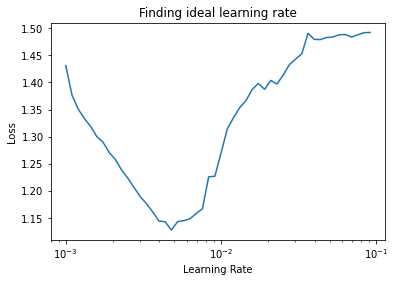

In [39]:
# 50 epochs
# Plot learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt

lrs_den = epochs/2

lrs = 1e-3 * (10**(np.arange(epochs)/25))
plt.semilogx(lrs, find_lr_history.history["loss"]) # We want the x-axis to be log-scaled
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Finding ideal learning rate");

In [40]:
tf.random.set_seed(42)
epochs=25

model_2 = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax"),
])

model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(learning_rate=0.002),
               metrics = ["accuracy"]
               )

find_lr_history = model_2.fit(train_ds,
                             validation_data = val_ds,
                             epochs=epochs)

Epoch 1/25
231/231 [==============================] - 2s 4ms/step - loss: 1.4041 - accuracy: 0.3646 - val_loss: 1.3984 - val_accuracy: 0.3651
Epoch 2/25
231/231 [==============================] - 1s 2ms/step - loss: 1.3527 - accuracy: 0.3986 - val_loss: 1.3818 - val_accuracy: 0.3711
Epoch 3/25
231/231 [==============================] - 1s 2ms/step - loss: 1.3268 - accuracy: 0.4126 - val_loss: 1.3783 - val_accuracy: 0.3749
Epoch 4/25
231/231 [==============================] - 1s 2ms/step - loss: 1.3032 - accuracy: 0.4298 - val_loss: 1.3939 - val_accuracy: 0.3814
Epoch 5/25
231/231 [==============================] - 1s 2ms/step - loss: 1.2835 - accuracy: 0.4398 - val_loss: 1.4174 - val_accuracy: 0.3689
Epoch 6/25
231/231 [==============================] - 1s 2ms/step - loss: 1.2563 - accuracy: 0.4598 - val_loss: 1.4021 - val_accuracy: 0.3841
Epoch 7/25
231/231 [==============================] - 0s 2ms/step - loss: 1.2275 - accuracy: 0.4691 - val_loss: 1.4464 - val_accuracy: 0.3537
Epoch 

Evaluate model accuracy against our test data set

In [41]:
model_2.evaluate(test_ds)

73/73 [==============================] - 0s 2ms/step - loss: 2.2923 - accuracy: 0.3319


[2.2922816276550293, 0.3318890929222107]

### Visualize Performance
Create a confusion matrix function to help us visualize our performance

In [42]:
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
            y_pred=y_preds, # predicted labels
            classes=class_names, # array of class label names
            figsize=(15, 15),
            text_size=10)
    """ 
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
        
    # Label the axes
    ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes), 
        xticklabels=labels, # axes will labeled with class names (if they exist) or ints
        yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)

In [43]:
y_probs = model_2.predict(test_ds)

y_probs[:5]

73/73 [==============================] - 0s 1ms/step


array([[1.5426303e-03, 3.5596523e-02, 3.7337133e-01, 2.1447897e-02,
        5.6804156e-01],
       [1.3613836e-03, 6.4759620e-02, 8.7796456e-01, 4.9495332e-02,
        6.4192316e-03],
       [8.7867454e-03, 2.6997449e-03, 3.0279124e-01, 2.5541455e-01,
        4.3030778e-01],
       [1.2416078e-02, 6.7946576e-02, 5.8922835e-02, 6.3104475e-01,
        2.2966973e-01],
       [5.8995641e-04, 2.4633346e-02, 2.0991421e-01, 3.6047518e-01,
        4.0438735e-01]], dtype=float32)

In [44]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
test_labels[:5]

array([4, 2, 2, 3, 3])

In [45]:
y_preds = y_probs.argmax(axis=1)

y_preds[:5]

array([4, 2, 4, 3, 4])

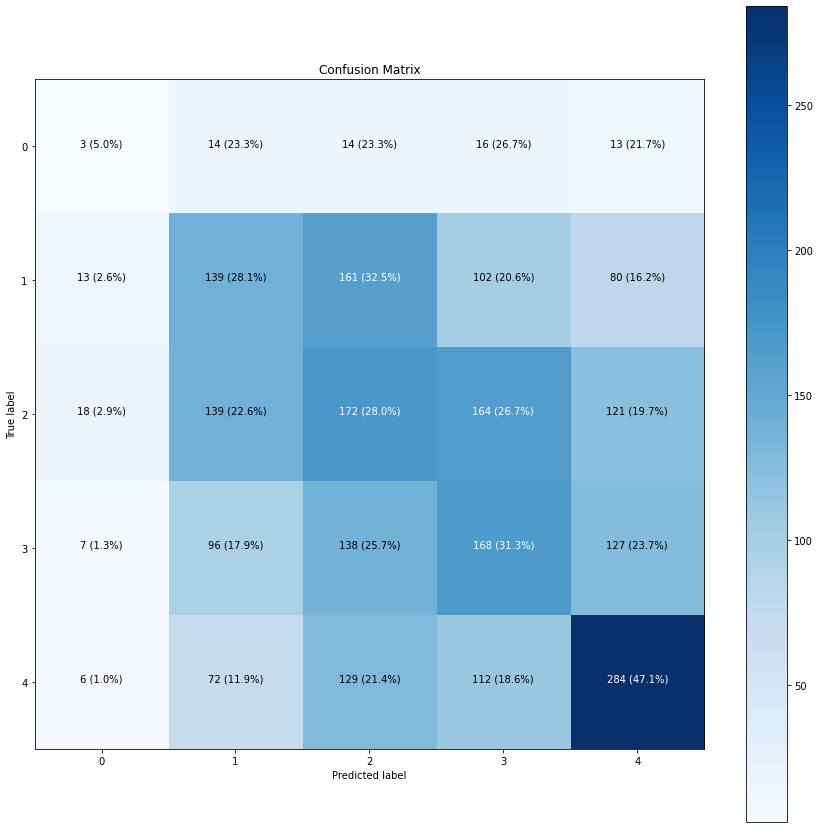

In [46]:
make_confusion_matrix(y_true=test_labels,
                     y_pred = y_preds,
                     figsize=(15, 15),
                     text_size=10)